In [232]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import scipy.io as sio

In [233]:
# Solve the problem of the minus sign '-' showing as a square when saving images
plt.rcParams['axes.unicode_minus'] = False

In [234]:
vp_orig = sio.loadmat('./model data/vp.mat')['vp']
vs_orig = sio.loadmat('./model data/vs.mat')['vs']
dn_orig = sio.loadmat('./model data/dn.mat')['dn']
cnl_orig = sio.loadmat('./model data/cnl.mat')['cnl']
gr_orig = sio.loadmat('./model data/gr.mat')['gr']

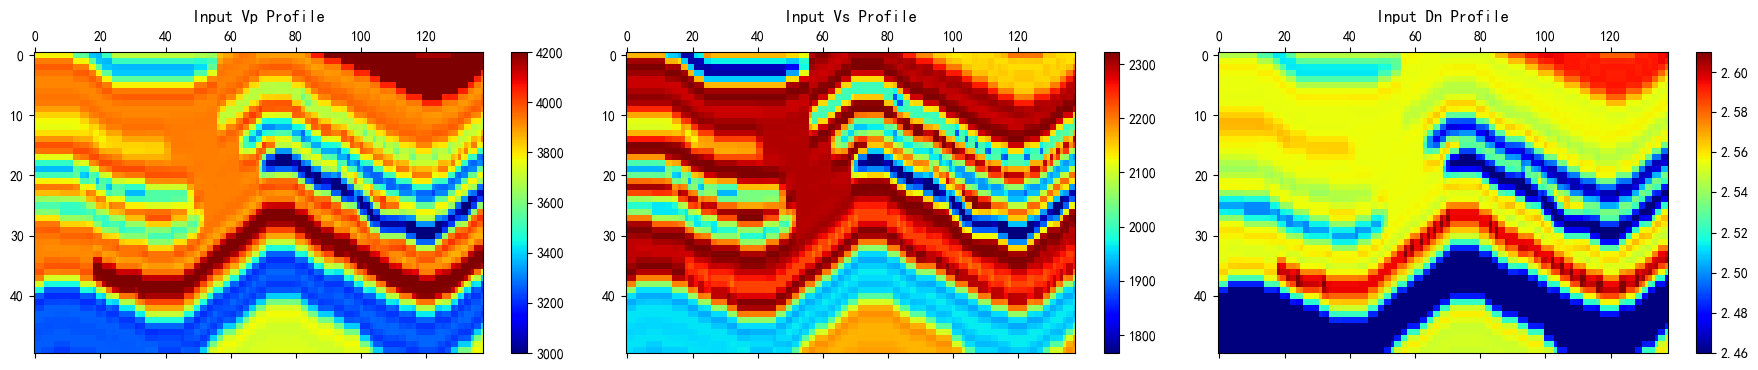

In [235]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
# Vp Profile
im1 = axes[0].matshow(vp_orig, aspect='auto', cmap='jet', vmin=3000, vmax=4200)
axes[0].set_title('Input Vp Profile')
fig.colorbar(im1, ax=axes[0])

# Vs Profile
im2 = axes[1].matshow(vs_orig, aspect='auto', cmap='jet', vmin=1767, vmax=2322)
axes[1].set_title('Input Vs Profile')
fig.colorbar(im2, ax=axes[1])

# Dn Profile
im3 = axes[2].matshow(dn_orig, aspect='auto', cmap='jet', vmin=2.46, vmax=2.61)
axes[2].set_title('Input Dn Profile')
fig.colorbar(im3, ax=axes[2])

plt.tight_layout(rect=[0, 0, 1, 0.95])

In [236]:
vp, vs, dn, cnl, gr = vp_orig.copy(), vs_orig.copy(), dn_orig.copy(), cnl_orig.copy(), gr_orig.copy()

In [237]:
scaler_vp = StandardScaler()
scaler_vs = StandardScaler()
scaler_dn = StandardScaler()
scaler_cnl = StandardScaler()
scaler_gr = StandardScaler()
vp = scaler_vp.fit_transform(vp)
vs = scaler_vs.fit_transform(vs)
dn = scaler_dn.fit_transform(dn)
cnl = scaler_cnl.fit_transform(cnl)
gr = scaler_gr.fit_transform(gr)

print("Data loading and standardization complete.")
print("VP data shape:", vp.shape)

Data loading and standardization complete.
VP data shape: (50, 138)


In [238]:
def create_dataset2(X, y, seq_len):
    features = []
    targets = []
    for i in range(len(X) - seq_len):
        data = X[i:i+seq_len]
        label = y[i + seq_len // 2]
        features.append(data)
        targets.append(label)
    return np.array(features), np.array(targets)

In [239]:
# Define a function to process the entire dataset
def process_data(data, data_name, seq_len):
    all_features, all_targets = [], []
    for col in range(data.shape[1]):
        features, targets = create_dataset2(data[:, col], data[:, col], seq_len)
        all_features.append(features)
        all_targets.append(targets)
    all_features = np.stack(all_features, axis=1)
    all_targets = np.stack(all_targets, axis=1)
    print(f"{data_name}_features shape: {all_features.shape}")
    return all_features, all_targets

In [240]:
# Set sequence length and process all data
Len1 = 3
vp_all_features, _ = process_data(vp, 'vp', Len1)
vs_all_features, _ = process_data(vs, 'vs', Len1)
dn_all_features, _ = process_data(dn, 'dn', Len1)
_, cnl_all_targets = process_data(cnl, 'cnl', Len1)
_, gr_all_targets = process_data(gr, 'gr', Len1)

# Combine input features (Vp, Vs, Dn)
vp_all_features_exp = np.expand_dims(vp_all_features, axis=-1)
vs_all_features_exp = np.expand_dims(vs_all_features, axis=-1)
dn_all_features_exp = np.expand_dims(dn_all_features, axis=-1)
vpvsden_fea = np.concatenate((vp_all_features_exp, vs_all_features_exp, dn_all_features_exp), axis=3)
print("\nCombined input feature shape:", vpvsden_fea.shape)

vp_features shape: (47, 138, 3)
vs_features shape: (47, 138, 3)
dn_features shape: (47, 138, 3)
cnl_features shape: (47, 138, 3)
gr_features shape: (47, 138, 3)

Combined input feature shape: (47, 138, 3, 3)


现在变成五口井预测

In [241]:
### 5. Split into Supervised and Semi-supervised Datasets
# Define well indices
all_well_indices = list(range(vpvsden_fea.shape[1]))
supervised_well_indices = [10, 35, 61, 98, 130]
unsupervised_well_indices = [i for i in all_well_indices if i not in supervised_well_indices]

# Prepare fully supervised data (X_sup, Y_sup)
X_sup_3d = vpvsden_fea[:, supervised_well_indices, :, :]
Y_sup_gr_3d = gr_all_targets[:, supervised_well_indices]
Y_sup_cnl_3d = cnl_all_targets[:, supervised_well_indices]

# Flatten for training
num_samples_sup, num_wells_sup, seq_len, num_features = X_sup_3d.shape
X_sup = X_sup_3d.reshape(num_samples_sup * num_wells_sup, seq_len * num_features)
Y_sup_gr = Y_sup_gr_3d.reshape(num_samples_sup * num_wells_sup)
Y_sup_cnl = Y_sup_cnl_3d.reshape(num_samples_sup * num_wells_sup)

# Prepare semi-supervised/unlabeled data (X_unsup)
X_unsup_3d = vpvsden_fea[:, unsupervised_well_indices, :, :]
print(f"\nSupervised data shape (X_sup): {X_sup.shape}")
print(f"Unlabeled data shape (X_unsup_3d): {X_unsup_3d.shape}")


Supervised data shape (X_sup): (235, 9)
Unlabeled data shape (X_unsup_3d): (47, 133, 3, 3)


In [242]:
def build_multi_output_stabgcn_model(input_shape):
    """
    Multi-output STABGCN model for simultaneous GR and CNL prediction
    """
    inputs = Input(shape=input_shape)
    features = input_shape[0]
    
    # --- 2D-CNN Branch ---
    side_length = int(np.ceil(np.sqrt(features)))
    padding_needed = side_length * side_length - features
    x_padded = tf.pad(inputs, [[0, 0], [0, padding_needed]])
    reshaped_2d = Reshape((side_length, side_length, 1))(x_padded)
    conv2d = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(reshaped_2d)
    pool = MaxPooling2D((2, 2))(conv2d)
    dropout_cnn = Dropout(0.2)(pool)
    cnn_flat = Flatten()(dropout_cnn)
    
    # --- BiGRU Branch ---
    seq_length = features // 3
    x_seq = Reshape((seq_length, 3))(inputs[:, :seq_length*3])
    bigru = Bidirectional(GRU(32, recurrent_regularizer=tf.keras.regularizers.l2(0.001), kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x_seq)
    dropout_gru = Dropout(0.2)(bigru)
    
    # Merge features
    merged = Concatenate()([cnn_flat, dropout_gru])
    
    # Shared layers
    shared = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    shared_dropout = Dropout(0.2)(shared)
    
    # GR prediction branch
    gr_branch = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    gr_dropout = Dropout(0.2)(gr_branch)
    gr_output = Dense(1, name='gr_output')(gr_dropout)
    
    # CNL prediction branch
    cnl_branch = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    cnl_dropout = Dropout(0.2)(cnl_branch)
    cnl_output = Dense(1, name='cnl_output')(cnl_dropout)
    
    model = Model(inputs=inputs, outputs=[gr_output, cnl_output])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, 
                  loss={'gr_output': 'mse', 'cnl_output': 'mse'},
                  loss_weights={'gr_output': 1.0, 'cnl_output': 1.0})
    return model

In [243]:
# Instantiate the main model
input_shape = (X_sup.shape[1],)
forward_model = build_multi_output_stabgcn_model(input_shape)
print("\nMain prediction model (Forward Model) built:")
forward_model.summary()


Main prediction model (Forward Model) built:
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 9)]                  0         []                            
                                                                                                  
 tf.compat.v1.pad_13 (TFOpL  (None, 9)                    0         ['input_13[0][0]']            
 ambda)                                                                                           
                                                                                                  
 reshape_24 (Reshape)        (None, 3, 3, 1)              0         ['tf.compat.v1.pad_13[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)          (None, 3, 3, 32)

In [244]:
# Load and freeze the inverse constraint model (Inverse Model)
try:
    inverse_model = load_model("inverse_prediction_model.h5")
    inverse_model.trainable = False
    print("\nInverse constraint model (Inverse Model) loaded and frozen successfully:")
    inverse_model.summary()
except IOError:
    print("\nError: 'inverse_prediction_model.h5' not found. Please run the inverse prediction script first to generate this model.")
    # In Jupyter, this can stop execution
    assert False, "Inverse model file is missing"


Inverse constraint model (Inverse Model) loaded and frozen successfully:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 tf.compat.v1.pad_3 (TFOpLa  (None, 4)                    0         ['input_4[0][0]']             
 mbda)                                                                                            
                                                                                                  
 reshape_6 (Reshape)         (None, 2, 2, 1)              0         ['tf.compat.v1.pad_3[0][0]']  
                                                                                                  
 conv2d_3 (Conv2D)

In [245]:
### 7. Custom Semi-supervised Training
# Define hyperparameters
epochs = 15
supervised_batch_size = 256
unsupervised_batch_size_wells = 10 # Process 10 unlabeled wells at a time
lambda_semi = 0.1  # Weight for the semi-supervised loss

# Define optimizer and loss function
optimizer = Adam(learning_rate=0.001)
mse_loss = tf.keras.losses.MeanSquaredError()

# Create a tf.data.Dataset for supervised data for efficient batching and shuffling
sup_dataset = tf.data.Dataset.from_tensor_slices((X_sup, (Y_sup_gr, Y_sup_cnl)))
sup_dataset = sup_dataset.shuffle(buffer_size=X_sup.shape[0]).batch(supervised_batch_size)

In [246]:
# Training loop
print("\nStarting semi-supervised training...")
history = {'total_loss': [], 'sup_loss': [], 'semi_loss': []}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Iterator to get batches from the supervised dataset
    sup_iterator = iter(sup_dataset)
    
    epoch_total_loss = []
    epoch_sup_loss = []
    epoch_semi_loss = []

    # Iterate through unlabeled data in batches of 10 wells
    for i in range(0, X_unsup_3d.shape[1], unsupervised_batch_size_wells):
        # Prepare a batch of unlabeled data
        X_batch_unsup_3d = X_unsup_3d[:, i:i+unsupervised_batch_size_wells, :, :]
        num_samples_unsup, num_wells_unsup, _, _ = X_batch_unsup_3d.shape
        X_batch_unsup = X_batch_unsup_3d.reshape(num_samples_unsup * num_wells_unsup, seq_len * num_features)
        
        # Prepare a batch of labeled data
        try:
            X_batch_sup, (Y_batch_sup_gr, Y_batch_sup_cnl) = next(sup_iterator)
        except StopIteration: # If supervised data is exhausted, recreate the iterator
            sup_iterator = iter(sup_dataset)
            X_batch_sup, (Y_batch_sup_gr, Y_batch_sup_cnl) = next(sup_iterator)

        with tf.GradientTape() as tape:
            # 1. Fully supervised part
            Y_pred_sup_gr, Y_pred_sup_cnl = forward_model(X_batch_sup, training=True)
            loss_sup_gr = mse_loss(Y_batch_sup_gr, Y_pred_sup_gr)
            loss_sup_cnl = mse_loss(Y_batch_sup_cnl, Y_pred_sup_cnl)
            loss_supervised = loss_sup_gr + loss_sup_cnl

            # 2. Semi-supervised part
            # Forward prediction
            Y_pred_unsup_gr, Y_pred_unsup_cnl = forward_model(X_batch_unsup, training=True)
            # Concatenate for the inverse model's input
            Y_pred_unsup_reshaped = tf.concat([Y_pred_unsup_gr, Y_pred_unsup_cnl], axis=1)
            # Inverse validation
            X_rec_unsup_vp, X_rec_unsup_vs, X_rec_unsup_dn = inverse_model(Y_pred_unsup_reshaped, training=False)
            # Concatenate the inverse model's output
            X_rec_unsup = tf.concat([X_rec_unsup_vp, X_rec_unsup_vs, X_rec_unsup_dn], axis=1)
            
            # [FIX] Calculate semi-supervised loss
            # The original input X_batch_unsup is a vector of length 9: [vp1,vs1,dn1, vp2,vs2,dn2, vp3,vs3,dn3]
            # The forward model predicts GR/CNL for the center point (t=2), and the inverse model reconstructs Vp/Vs/Dn for the center point (t=2).
            # Therefore, we should compare with the Vp/Vs/Dn of the center point (t=2) from the original input.
            # Vp(t=2) is at index 3, Vs(t=2) at index 4, Dn(t=2) at index 5
            center_point_idx = seq_len // 2
            
            X_batch_unsup_vp_center = X_batch_unsup[:, center_point_idx * 3 + 0] # Vp of the center point
            X_batch_unsup_vs_center = X_batch_unsup[:, center_point_idx * 3 + 1] # Vs of the center point
            X_batch_unsup_dn_center = X_batch_unsup[:, center_point_idx * 3 + 2] # Dn of the center point
            
            loss_semi_vp = mse_loss(X_batch_unsup_vp_center, X_rec_unsup_vp)
            loss_semi_vs = mse_loss(X_batch_unsup_vs_center, X_rec_unsup_vs)
            loss_semi_dn = mse_loss(X_batch_unsup_dn_center, X_rec_unsup_dn)
            loss_semi_supervised = loss_semi_vp + loss_semi_vs + loss_semi_dn

            # 3. Combine total loss
            total_loss = loss_supervised + lambda_semi * loss_semi_supervised

        # 4. Backpropagation and optimization
        gradients = tape.gradient(total_loss, forward_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, forward_model.trainable_variables))
        
        epoch_total_loss.append(total_loss.numpy())
        epoch_sup_loss.append(loss_supervised.numpy())
        epoch_semi_loss.append(loss_semi_supervised.numpy())

    # Record and print the average loss for each epoch
    avg_total_loss = np.mean(epoch_total_loss)
    avg_sup_loss = np.mean(epoch_sup_loss)
    avg_semi_loss = np.mean(epoch_semi_loss)
    history['total_loss'].append(avg_total_loss)
    history['sup_loss'].append(avg_sup_loss)
    history['semi_loss'].append(avg_semi_loss)
    print(f"  - loss: {avg_total_loss:.4f} - sup_loss: {avg_sup_loss:.4f} - semi_loss: {avg_semi_loss:.4f}")

print("Model training complete.")


Starting semi-supervised training...
Epoch 1/15
  - loss: 1.5023 - sup_loss: 1.1253 - semi_loss: 3.7702
Epoch 2/15
  - loss: 0.9187 - sup_loss: 0.4637 - semi_loss: 4.5497
Epoch 3/15
  - loss: 0.8085 - sup_loss: 0.3849 - semi_loss: 4.2362
Epoch 4/15
  - loss: 0.7659 - sup_loss: 0.3350 - semi_loss: 4.3091
Epoch 5/15
  - loss: 0.7447 - sup_loss: 0.3158 - semi_loss: 4.2895
Epoch 6/15
  - loss: 0.7264 - sup_loss: 0.2951 - semi_loss: 4.3129
Epoch 7/15
  - loss: 0.7071 - sup_loss: 0.2794 - semi_loss: 4.2770
Epoch 8/15
  - loss: 0.6908 - sup_loss: 0.2596 - semi_loss: 4.3119
Epoch 9/15
  - loss: 0.6746 - sup_loss: 0.2440 - semi_loss: 4.3066
Epoch 10/15
  - loss: 0.6673 - sup_loss: 0.2342 - semi_loss: 4.3309
Epoch 11/15
  - loss: 0.6505 - sup_loss: 0.2208 - semi_loss: 4.2971
Epoch 12/15
  - loss: 0.6443 - sup_loss: 0.2108 - semi_loss: 4.3352
Epoch 13/15
  - loss: 0.6325 - sup_loss: 0.1992 - semi_loss: 4.3327
Epoch 14/15
  - loss: 0.6295 - sup_loss: 0.1956 - semi_loss: 4.3385
Epoch 15/15
  - los

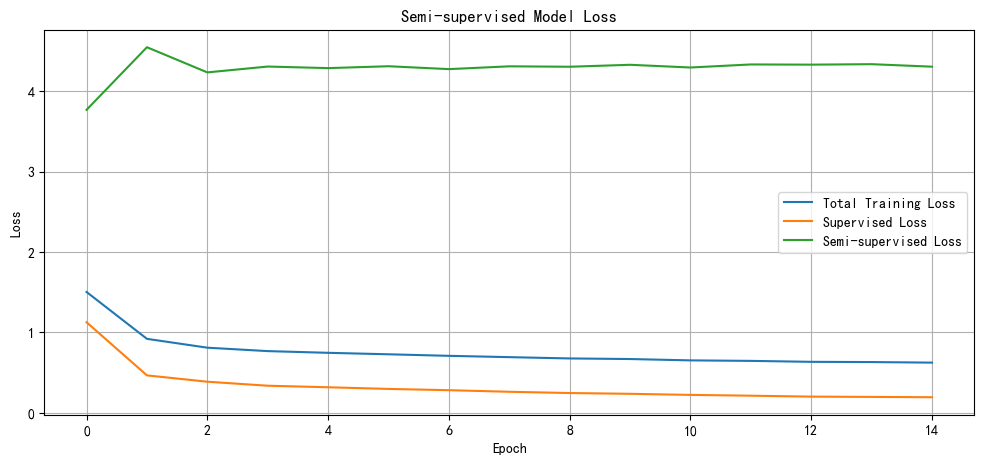

In [247]:
### 8. Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.plot(history['total_loss'], label='Total Training Loss')
plt.plot(history['sup_loss'], label='Supervised Loss')
plt.plot(history['semi_loss'], label='Semi-supervised Loss')
plt.title('Semi-supervised Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [248]:
### 9. Predict and Evaluate on the Entire Dataset
# Prepare the complete dataset for prediction
total_samples, total_wells, _, _ = vpvsden_fea.shape
X_predict = vpvsden_fea.reshape(total_samples * total_wells, seq_len * num_features)

print("\nStarting prediction on the entire dataset...")
predictions_gr_flat, predictions_cnl_flat = forward_model.predict(X_predict)

# Reshape to profile format
predictions_gr = predictions_gr_flat.reshape(total_samples, total_wells)
predictions_cnl = predictions_cnl_flat.reshape(total_samples, total_wells)

# Inverse transform to original scale
predictions_gr_orig = scaler_gr.inverse_transform(predictions_gr)
predictions_cnl_orig = scaler_cnl.inverse_transform(predictions_cnl)

# Get true labels
y_test_gr_orig = gr_orig[:total_samples, :]
y_test_cnl_orig = cnl_orig[:total_samples, :]

# Calculate overall R² score
r2_gr = r2_score(gr_all_targets.flatten(), predictions_gr.flatten())
r2_cnl = r2_score(cnl_all_targets.flatten(), predictions_cnl.flatten())
print(f"\nOverall R² score for GR prediction: {r2_gr:.4f}")
print(f"Overall R² score for CNL prediction: {r2_cnl:.4f}")


Starting prediction on the entire dataset...
203/203 [==============================] - 1s 2ms/step

Overall R² score for GR prediction: 0.9471
Overall R² score for CNL prediction: 0.9077


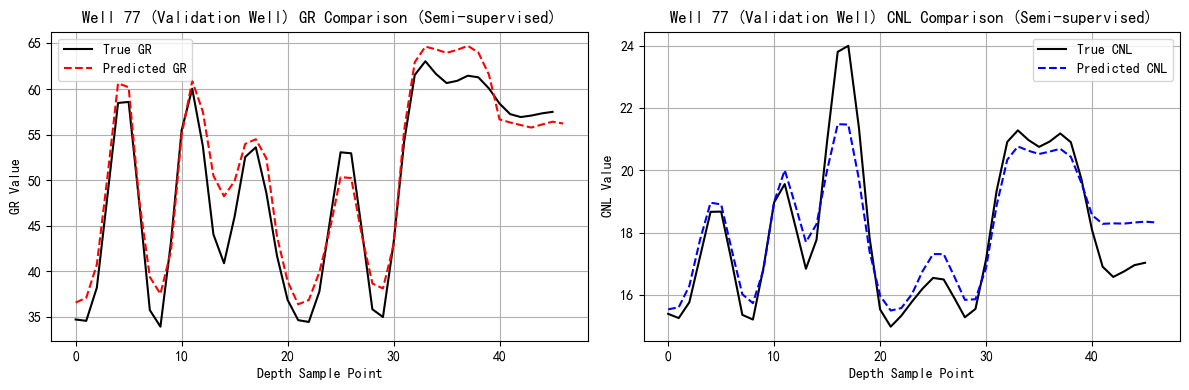

C:\Users\MJ\AppData\Local\Temp\ipykernel_22676\551601171.py:59: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()


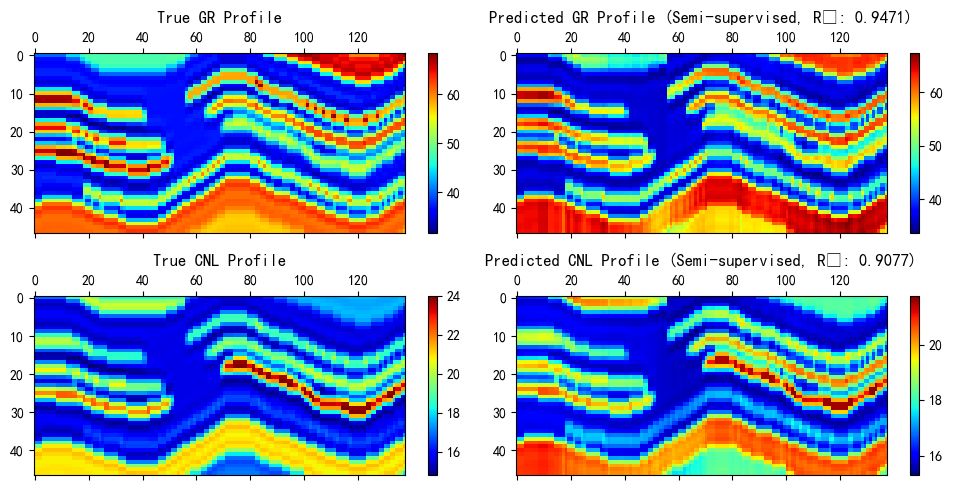

In [251]:
### 10. Visualize Results
# Visualize the comparison for the entire profile
# Supervised well indices are [10, 35, 61, 98, 130], choose an index not in this list
well_idx_to_plot = 77 

# Prepare data for plotting
# Due to sequence processing, the prediction length is shorter than the original data by (seq_len - 1) points
# True labels need to be aligned accordingly
start_idx = (Len1 - 1) // 2
end_idx = start_idx + predictions_gr_orig.shape[0]
true_gr_well = y_test_gr_orig[start_idx:end_idx, well_idx_to_plot]
true_cnl_well = y_test_cnl_orig[start_idx:end_idx, well_idx_to_plot]
pred_gr_well = predictions_gr_orig[:, well_idx_to_plot]
pred_cnl_well = predictions_cnl_orig[:, well_idx_to_plot]

# Plotting
plt.figure(figsize=(12, 4))

# GR Comparison
plt.subplot(1, 2, 1)
plt.plot(true_gr_well, 'k-', label='True GR')
plt.plot(pred_gr_well, 'r--', label='Predicted GR')
plt.title(f'Well {well_idx_to_plot} (Validation Well) GR Comparison (Semi-supervised)')
plt.xlabel('Depth Sample Point')
plt.ylabel('GR Value')
plt.legend()
plt.grid(True)

# CNL Comparison
plt.subplot(1, 2, 2)
plt.plot(true_cnl_well, 'k-', label='True CNL')
plt.plot(pred_cnl_well, 'b--', label='Predicted CNL')
plt.title(f'Well {well_idx_to_plot} (Validation Well) CNL Comparison (Semi-supervised)')
plt.xlabel('Depth Sample Point')
plt.ylabel('CNL Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(10, 5))
# GR
im1 = axes[0, 0].matshow(y_test_gr_orig, aspect='auto', cmap='jet')
axes[0, 0].set_title('True GR Profile')
fig.colorbar(im1, ax=axes[0, 0])
im2 = axes[0, 1].matshow(predictions_gr_orig, aspect='auto', cmap='jet')
axes[0, 1].set_title(f'Predicted GR Profile (Semi-supervised, R²: {r2_gr:.4f})')
fig.colorbar(im2, ax=axes[0, 1])
# CNL
im3 = axes[1, 0].matshow(y_test_cnl_orig, aspect='auto', cmap='jet')
axes[1, 0].set_title('True CNL Profile')
fig.colorbar(im3, ax=axes[1, 0])
im4 = axes[1, 1].matshow(predictions_cnl_orig, aspect='auto', cmap='jet')
axes[1, 1].set_title(f'Predicted CNL Profile (Semi-supervised, R²: {r2_cnl:.4f})')
fig.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

In [250]:
# ### 11. Save Prediction Results
# sio.savemat("predicted_gr_cnl_semisupervised.mat", {
#     "predicted_gr": predictions_gr_orig,
#     "predicted_cnl": predictions_cnl_orig
# })

Comparison of True, Supervised, and Semi-supervised Predictions

Supervised model prediction results loaded successfully.


C:\Users\MJ\AppData\Local\Temp\ipykernel_22676\2746250281.py:41: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
d:\study\miniconda\enviroment\envs\shit\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


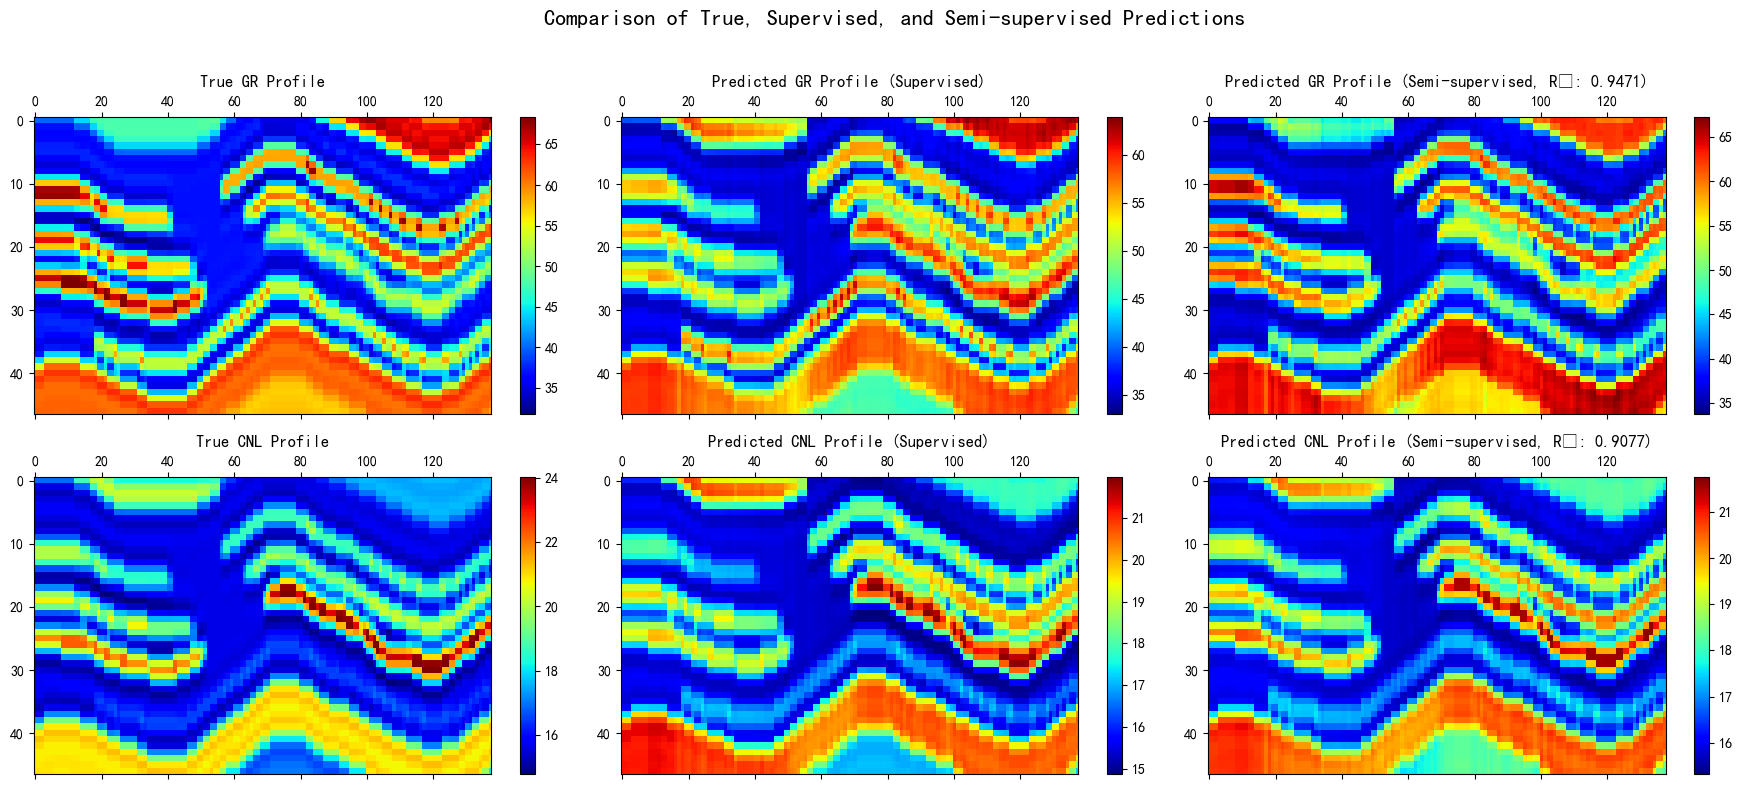

In [252]:
sup_gr_pred = sio.loadmat("gr_predicted_supervised.mat")["predicted_gr"]
sup_cnl_pred = sio.loadmat("cnl_predicted_supervised.mat")["predicted_cnl"]
print("Supervised model prediction results loaded successfully.")

# Create a 2x3 plot for comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Comparison of True, Supervised, and Semi-supervised Predictions', fontsize=16)

# --- Row 1: GR Profiles ---
# True GR
im1 = axes[0, 0].matshow(y_test_gr_orig, aspect='auto', cmap='jet')
axes[0, 0].set_title('True GR Profile')
fig.colorbar(im1, ax=axes[0, 0])

# Supervised GR Prediction
im2 = axes[0, 1].matshow(sup_gr_pred, aspect='auto', cmap='jet')
axes[0, 1].set_title('Predicted GR Profile (Supervised)')
fig.colorbar(im2, ax=axes[0, 1])

# Semi-supervised GR Prediction
im3 = axes[0, 2].matshow(predictions_gr_orig, aspect='auto', cmap='jet')
axes[0, 2].set_title(f'Predicted GR Profile (Semi-supervised, R²: {r2_gr:.4f})')
fig.colorbar(im3, ax=axes[0, 2])

# --- Row 2: CNL Profiles ---
# True CNL
im4 = axes[1, 0].matshow(y_test_cnl_orig, aspect='auto', cmap='jet')
axes[1, 0].set_title('True CNL Profile')
fig.colorbar(im4, ax=axes[1, 0])

# Supervised CNL Prediction
im5 = axes[1, 1].matshow(sup_cnl_pred, aspect='auto', cmap='jet')
axes[1, 1].set_title('Predicted CNL Profile (Supervised)')
fig.colorbar(im5, ax=axes[1, 1])

# Semi-supervised CNL Prediction
im6 = axes[1, 2].matshow(predictions_cnl_orig, aspect='auto', cmap='jet')
axes[1, 2].set_title(f'Predicted CNL Profile (Semi-supervised, R²: {r2_cnl:.4f})')
fig.colorbar(im6, ax=axes[1, 2])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()